This script compiles the results and generate plots for to show average compression ratio, speedup with different processors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [2]:
df = pd.read_csv("parallelRandomizedCPGCResults_PSC.csv")
seq_df = pd.read_csv("sequentialRandomizedCPGCResults_PSC_v3.csv")
# list(df.columns)

In [3]:
nodes = list(df['graphNodes'].unique())
density = list(df['density'].unique())
expNo = list(df['expNo'].unique())
cores = [16, 32, 48, 64, 80, 96, 112, 128]
delta = list(df['delta'].unique())

In [4]:
def shorten_number(number):
    if abs(number) >= 1e9:
        return r"{:.2f} B".format(number / 1e9)
    elif abs(number) >= 1e6:
        return r"{:.2f} M".format(number / 1e6)
    elif abs(number) >= 1e3:
        return r"{:.2f} K".format(number / 1e3)
    else:
        return str(int(number))

In [5]:
color = ['gainsboro', 'silver', 'darkgrey', 'grey', 'dimgrey']

In [6]:
node_map = {
    2048: r'4 K',
    4096: r'8 K',
    8192: r'16 K',
    16384: r'32 K',
    32768: r'65 K'
}
node_map
nodes1 = [node_map[n] if n in node_map else n for n in nodes]
# nodes1

In [7]:
def remove_outliers(data):
#     print(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    filtered_data = [x for x in data if (x >= lower_bound and x <= upper_bound)]
    return filtered_data # # round(np.mean(filtered_data), 2) # filtered_data # 

In [8]:
# edges_map_80 = {
#     2048: r'3.3M',
#     4096: r'13.4M',
#     8192: r'53.6M',
#     16384: r'214.8M',
#     32768: r'858.9M'
# }

# edges_80 = [edges_map_80[n] if n in edges_map_80 else n for n in nodes]
# edges_80

In [9]:
avgCompRatio = {}
avgExeTime = {}
avgWriteTime = {} 
avgReadTime =  {}
avgMergeTime =  {}
seq_avgExeTime = {}

for n in nodes:
    for d in density:
        for e in expNo:
            for de in delta:
                seq_avgExeTime[(n,d,e,de)] = remove_outliers(seq_df[(seq_df['graphNodes'] == n) & (seq_df['density'] == d) & (seq_df['expNo'] == e) & 
                                  (seq_df['delta'] == de)].executionTime.tolist())
                for c in cores:
#                     print(n,d,e,c,de)
                    avgCompRatio[(n,d,e,c,de)] = remove_outliers(df[(df['graphNodes'] == n) & (df['density'] == d) & (df['expNo'] == e) & 
                                      (df['cores'] == c)  & (df['delta'] == de)].compressionRatio.tolist())
                    avgExeTime[(n,d,e,c,de)] = remove_outliers(df[(df['graphNodes'] == n) & (df['density'] == d) & (df['expNo'] == e) & 
                                      (df['cores'] == c)  & (df['delta'] == de)].executionTime.tolist())
                    avgWriteTime[(n,d,e,c,de)] = remove_outliers(df[(df['graphNodes'] == n) & (df['density'] == d) & (df['expNo'] == e) & 
                                      (df['cores'] == c)  & (df['delta'] == de)].writeTime.tolist())
                    avgReadTime[(n,d,e,c,de)] = remove_outliers(df[(df['graphNodes'] == n) & (df['density'] == d) & (df['expNo'] == e) & 
                                      (df['cores'] == c)  & (df['delta'] == de)].readTime.tolist())
                    avgMergeTime[(n,d,e,c,de)] = remove_outliers(df[(df['graphNodes'] == n) & (df['density'] == d) & (df['expNo'] == e) & 
                                      (df['cores'] == c)  & (df['delta'] == de)].mergeTime.tolist())

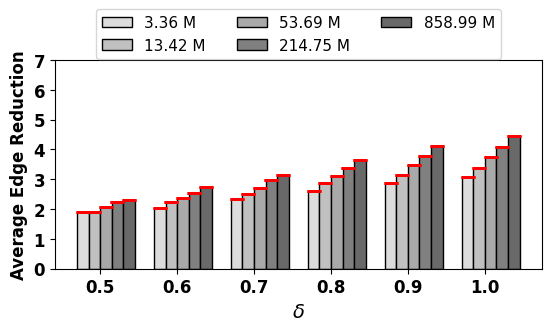

[2.3084578000000002, 2.7318910000000005, 3.1589466666666666, 3.6635826000000002, 4.1093662, 4.459058000000001]


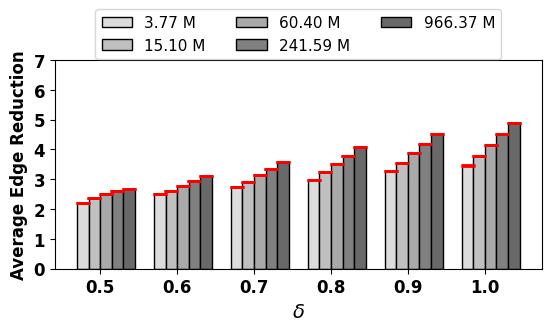

[2.6849246, 3.112703, 3.5923206, 4.073963, 4.529559000000001, 4.89528525]


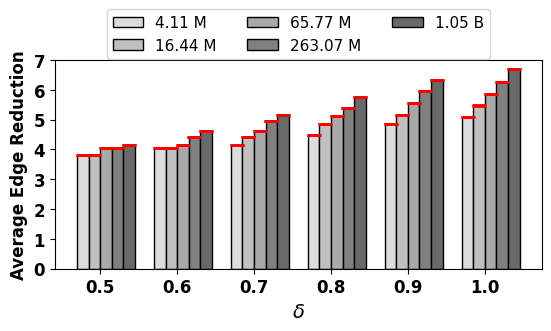

[4.1532395, 4.622009199999999, 5.173743, 5.765473200000001, 6.321687, 6.695008666666666]


In [10]:
# we want to show that increasing delta increases the compression rate therefore we plot for fixed density and fixed cores
# x axis is delta and y axis is compression ratio for 3 different nodes

for c in [16]:
    for d in [80, 90, 98]:
        e = 1
        plotData = {}
        plotStd = {}
        for n in nodes:
            plotData[n] = []
            plotStd[n] = []
            for de in delta:
                plotData[n].append(np.mean(avgCompRatio[(n,d,e,c,de)]))
                plotStd[n].append(statistics.stdev(avgCompRatio[(n,d,e,c,de)]))

        bar_width = 0.15  # Width of each bar
        x = np.arange(len(delta))  # X-axis values
        f, axes = plt.subplots(constrained_layout=True, figsize=[5.4, 3.2])
        i = 0
        
        for n in nodes:
            plt.bar(x + i * bar_width - (0.5 * bar_width), plotData[n], width=bar_width, label= f'{shorten_number(n**2 * d/100)}', color = color[i], edgecolor = 'k', yerr=plotStd[n], error_kw=dict(elinewidth=5, capsize=5, capthick=2, ecolor = 'red'))
            i = i + 1

        plt.xlabel('$\delta$', fontsize=14, weight = 'bold')
        plt.ylabel('Average Edge Reduction', fontsize=12, weight = 'bold')
#         plt.title(f'For {d}% density and {c} cores', fontsize=11, weight = 'bold')
        plt.xticks(x + bar_width, delta, fontsize=12, weight = 'bold')
        plt.yticks(fontsize=12, weight = 'bold')
        plt.legend(ncol = 3, fontsize=11, loc = 'upper center', bbox_to_anchor = (0.5, 1.28))
        plt.ylim(0,7)
        plt.savefig(f'plots/compression_ratio_vs_delta_with_density_{d}_for_cores_{c}_v2.pdf', dpi=300)
        plt.show()
        print(plotData[n])

2048 [2.0524187499999997, 2.20888725, 2.5121386, 3.0141174, 4.037964]
4096 [2.2298332, 2.4011725, 2.5928922, 3.1575512000000003, 4.0459248]
8192 [2.3716695999999997, 2.5384794, 2.76220975, 3.266363333333333, 4.1497335]
16384 [2.535484, 2.7024630000000003, 2.9315454, 3.4427532, 4.4331844]
32768 [2.7318910000000005, 2.9049438000000003, 3.112703, 3.650735, 4.622009199999999]


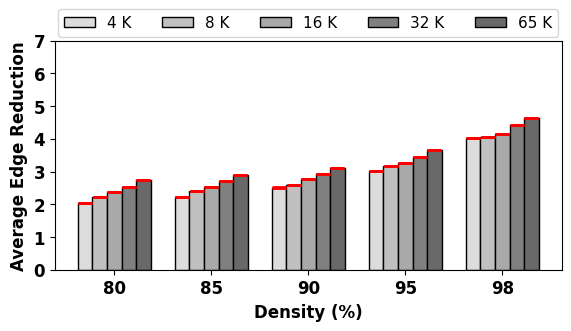

2048 [2.610326, 2.777777, 2.9797382000000003, 3.5273053999999995, 4.499737]
4096 [2.86768225, 3.004151333333333, 3.2556308, 3.76984825, 4.848532799999999]
8192 [3.10786775, 3.279372, 3.5185595000000003, 4.0332165, 5.13864125]
16384 [3.3835657500000003, 3.56115375, 3.7787498, 4.33532175, 5.3893211999999995]
32768 [3.6635826000000002, 3.824148, 4.073963, 4.6298297999999996, 5.765473200000001]


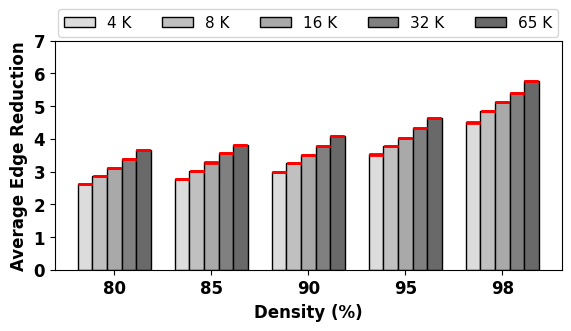

2048 [3.0829530000000003, 3.2299478, 3.4638850000000003, 4.009042600000001, 5.0893048]
4096 [3.3906158, 3.5479182000000002, 3.7910984, 4.3295004, 5.476343]
8192 [3.7373646666666662, 3.916439333333333, 4.155482999999999, 4.7033676, 5.8762226]
16384 [4.0981136, 4.2834912, 4.5240122, 5.0686729999999995, 6.271724000000001]
32768 [4.459058000000001, 4.6510932, 4.89528525, 5.43191775, 6.695008666666666]


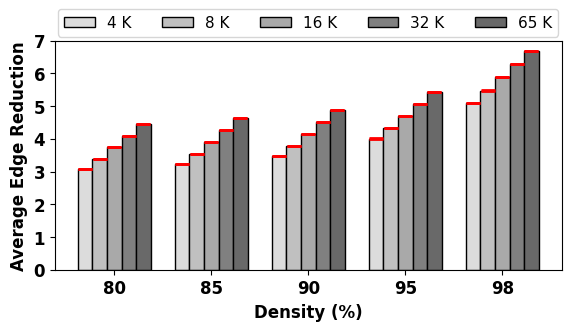

In [11]:
# we want to show that with increasing density increases the compression ratio therefore we plot for fixed cores and fixed delta
# x axis is density and y axis is execution time for 3 different nodes

e = 1
# density2.remove(100)
density2 = [80, 85, 90, 95, 98]
c = 16
for de in [0.6, 0.8, 1]:
    plotData = {}
    plotStd = {}
    for n in nodes:
        plotData[n] = []
        plotStd[n] = []
        for d in density2:
            plotData[n].append(np.mean(avgCompRatio[(n,d,e,c,de)]))
            plotStd[n].append(statistics.stdev(avgCompRatio[(n,d,e,c,de)]))

    bar_width = 0.15  # Width of each bar
    x = np.arange(len(density2))  # X-axis values
    f, axes = plt.subplots(constrained_layout=True, figsize=[5.6, 3.2])
    i = 0
    
    for n in nodes:
        power = nodes1[i]
        plt.bar(x + i * bar_width - ( bar_width), plotData[n], width=bar_width, label= f"{power}", color = color[i], edgecolor = 'k', yerr=plotStd[n], error_kw=dict(elinewidth=3, capsize=5, capthick=2, ecolor = 'red'))
        i = i + 1
        print(n, plotData[n])
    fc = 11
    # Adding labels, title, and legend
    plt.xlabel('Density (%)', fontsize=12, weight = 'bold')
    plt.ylabel('Average Edge Reduction', fontsize=12, weight = 'bold')
#     plt.title(f'For {c} processors and {de} delta', fontsize=11, weight = 'bold')
    plt.xticks(x + bar_width, density2, fontsize=12, weight = 'bold')
    plt.yticks(fontsize=12, weight = 'bold')
    plt.legend(ncol = 6, fontsize=11, loc = 'upper center', bbox_to_anchor = (0.5, 1.17))
    plt.ylim(0,7)
    plt.savefig(f'plots/avg_compression_ratio_vs_density_for_delta_{de}_cores_{c}_v2.pdf', dpi=300)
    plt.show()

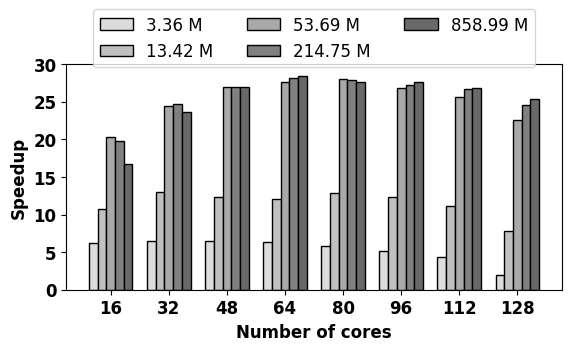

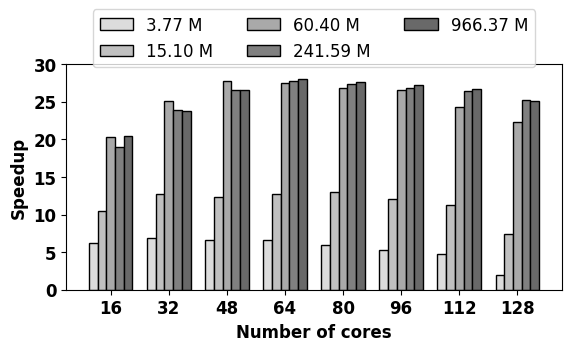

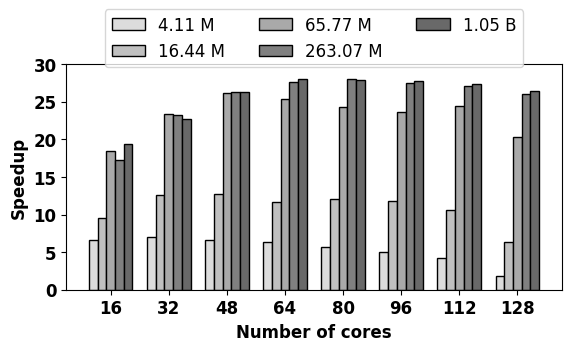

In [12]:

# we want to show that with increasing cores decreses the execution time therefore we plot for fixed density and fixed delta
# x axis is cores and y axis is execution time for 3 different nodes
# seq_avgExeTime[(n,d,e,de)]
e = 1
density2 = [80, 90, 98]
cores = [16, 32, 48, 64, 80, 96, 112, 128]
for de in [0.9]:  # the list will generate the plots for specified delta used in the experiment
    for d in density2:
        plotData = {}
#         plotStd = {}
        for n in nodes:
            plotData[n] = []   
#             plotStd[n] = []
            for c in cores:
                plotData[n].append(np.mean(seq_avgExeTime[(n,d,e,de)])/np.mean(avgExeTime[(n,d,e,c,de)]))
#                 plotStd[n].append(statistics.stdev(avgExeTime[(n,d,e,c,de)]))

        bar_width = 0.15  # Width of each bar
        x = np.arange(len(cores))  # X-axis values
        f, axes = plt.subplots(constrained_layout=True, figsize=[5.6, 3.4])
        i = 0
        
        for n in nodes:
            power = nodes1[i]
            plt.bar(x + i * bar_width - ( bar_width), plotData[n], width=bar_width, label=  f'{shorten_number(n**2 * d/100)}', color = color[i], edgecolor = 'k')
            i = i + 1
#             print(plotData[n]) # uncomment if need to see the values

        fc = 11
        # Adding labels, title, and legend
        plt.xlabel('Number of cores', fontsize=12, weight = 'bold')
        plt.ylabel('Speedup', fontsize=12, weight = 'bold')
#         plt.title(f'For {d}% density and {de} delta', fontsize=16, weight = 'bold')
        plt.xticks(x + bar_width, cores, fontsize=12, weight = 'bold')
        plt.yticks(fontsize=12, weight = 'bold')
        plt.legend(ncol = 3, fontsize=12, loc = 'upper center', bbox_to_anchor = (0.5, 1.28))
        plt.ylim(0, 30)
        plt.savefig(f'plots/speedup_vs_cores_density_{d}_delta_{de}_v2.pdf', dpi=300)
        plt.show()


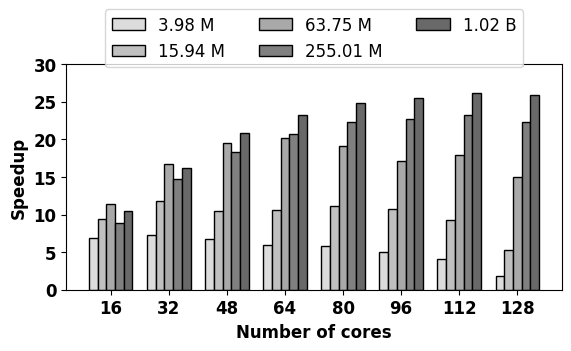

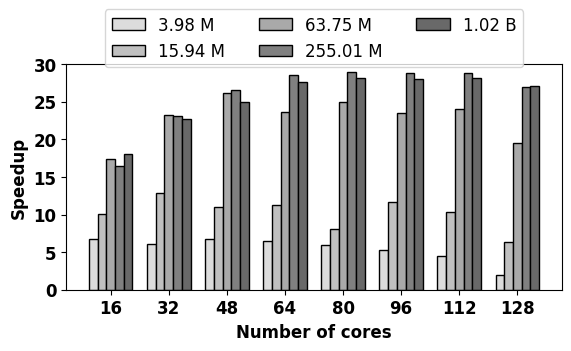

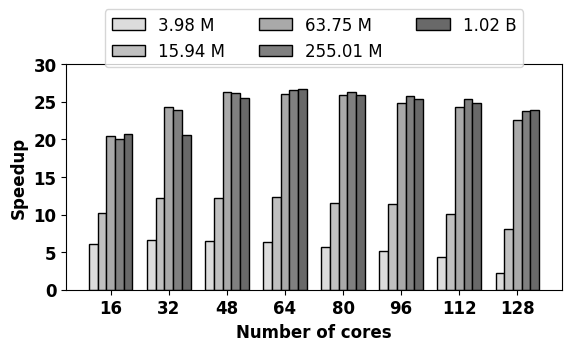

In [13]:
# we want to show that with increasing cores decreses the execution time therefore we plot for fixed density and fixed delta
# x axis is cores and y axis is execution time for 3 different nodes
# seq_avgExeTime[(n,d,e,de)]
e = 1
density2 = [95] # provide specific density to generate plots
for de in [0.6, 0.8, 1]:
    for d in density2:
        plotData = {}
        for n in nodes:
            plotData[n] = []   
            for c in cores:
                plotData[n].append(np.mean(seq_avgExeTime[(n,d,e,de)])/np.mean(avgExeTime[(n,d,e,c,de)]))

        bar_width = 0.15  # Width of each bar
        x = np.arange(len(cores))  # X-axis values
        f, axes = plt.subplots(constrained_layout=True, figsize=[5.6, 3.4])
        i = 0
        
        for n in nodes:
            power = nodes1[i]
            plt.bar(x + i * bar_width - ( bar_width), plotData[n], width=bar_width, label=  f'{shorten_number(n**2 * d/100)}', color = color[i], edgecolor = 'k')
            i = i + 1
#             print(plotData[n]) # uncomment if need to see the values

        fc = 11
        # Adding labels, title, and legend
        plt.xlabel('Number of cores', fontsize=12, weight = 'bold')
        plt.ylabel('Speedup', fontsize=12, weight = 'bold')
#         plt.title(f'For {d}% density and {de} delta', fontsize=16, weight = 'bold')
        plt.xticks(x + bar_width, cores, fontsize=12, weight = 'bold')
        plt.yticks(fontsize=12, weight = 'bold')
        plt.legend(ncol = 3, fontsize=12, loc = 'upper center', bbox_to_anchor = (0.5, 1.28))
        plt.ylim(0, 30)
        plt.savefig(f'plots/speedup_vs_cores_density_{d}_delta_{de}_v2.pdf', dpi=300)
        plt.show()